In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.stats import linregress
import os
from pathlib import Path
import re
import finufft

# Function to read .okc database files from Visit
def extract_fields_from_okc(file_path, fields):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Read header to get number of fields and points
    header = lines[0].strip()
    n_fields, n_points, foo = map(int, header.split())
    # Read field names in the next n_fields lines
    field_names = [line.strip() for line in lines[1:(n_fields + 1)]]

    # Data starts at line 2 * n_fields + 1
    start_data_lines = (2 * n_fields + 1)

    df = pd.read_csv(file_path, sep=r'\s+', skiprows=start_data_lines, names=field_names)
    sliced_df = df[fields]
    return sliced_df

def cartesian_df_to_polar(dataframe):
    df = dataframe
    r = np.sqrt(df['x'].values ** 2 + df['y'].values ** 2)
    theta = np.arctan2(df['y'].values, df['x'].values)
    r_mean = np.mean(r)
    r_fluct = r - r_mean
    return theta, r_mean, r_fluct

def interpolated_spline_FFT(theta, signal, os_fact=1):
    # Define uniform theta range 
    theta_uniform = np.linspace(theta[0], theta[-1], int(os_fact*len(theta)), endpoint=True)

    # Interpolate r to uniform theta
    r_interp = interp1d(theta, signal, kind='cubic')
    r_uniform = r_interp(theta_uniform)
    d_theta = theta_uniform[1] - theta_uniform[0]

    # Perform the Fourier Transform
    fft_coeffs = np.fft.fft(r_uniform)
    spect_wave_num = np.fft.fftfreq(len(r_uniform), d_theta)
    # Convert to one-sided over angular frequency
    pos_ind = len(spect_wave_num) // 2
    wave_num = 2 * np.pi * spect_wave_num[:pos_ind]

    # Get magnitudes and normalize by sample spacing d_theta
    amplitudes = np.abs(fft_coeffs)[:pos_ind] * d_theta
    return wave_num, amplitudes

# Function to calculate FFT after interpolation using an univariate spline, smooting = 0 is equal to the interp1d function
def interpolated_smooth_FFT(x, f, n_grid=-1, n_modes=-1, smoothing=0):
    # Define unifrom grid with n_grid gridpoints
    if n_grid < 0: n_grid = len(x)
    x_uniform = np.linspace(x[0], x[-1], n_grid, endpoint=True)

    # Interpolate f to x_uniform
    spline = UnivariateSpline(x, f, s=smoothing)
    f_uniform = spline(x_uniform)
    dx = x_uniform[1] - x_uniform[0]

    # Perform the Fourier Transform
    fft_coeffs = np.fft.fft(f_uniform)
    spect_wave_nums = np.fft.fftfreq(len(f_uniform), dx)
    
    # Convert to one-sided over angular wavenumber and normalize the amplitude
    pos_ind = len(spect_wave_nums) // 2
    if n_modes < 0:
        wave_nums = 2 * np.pi * spect_wave_nums[:pos_ind]   
        amplitudes = np.abs(fft_coeffs)[:pos_ind] * dx
    else:
        if n_modes > pos_ind: print("[WARNING] requested number of modes is higher than possible")
        wave_nums = 2 * np.pi * spect_wave_nums[:n_modes]
        amplitudes = np.abs(fft_coeffs)[:n_modes] * dx

    return wave_nums, amplitudes

def interpolated_NUFFT(x, f, modes, n_grid=-1):
    # Define unifrom grid with n_grid gridpoints
    if n_grid < 0: n_grid = len(x)
    x_uniform = np.linspace(x[0], x[-1], n_grid, endpoint=True)

    # Interpolate f to x_uniform
    spline = interp1d(x, f, kind='cubic')
    f_uniform = spline(x_uniform)
    dx = x_uniform[1] - x_uniform[0]

    wave_nums = np.asarray(modes, dtype=np.float64)    
    f_uniform = np.asarray(f_uniform, dtype=np.complex128)
    coeffs = finufft.nufft1d3(x_uniform, f_uniform, wave_nums)
    amplitudes = np.abs(coeffs) * dx
    return wave_nums, amplitudes

def least_squares_fit(x, f, n_modes=10, modes=None):
    # Manual mode switch
    if modes.all == None: wave_nums = np.arange(n_modes)
    else: wave_nums = modes
    
    # Design matrix for complex exponentials
    A = np.exp(1j * np.outer(x, wave_nums))  # shape (N, kmax)
    
    # Solve least squares for Fourier coefficients
    coeffs, *_ = np.linalg.lstsq(A, f, rcond=None)
    amplitudes = np.abs(coeffs)
    return wave_nums, amplitudes

def get_dominant_mode(theta, signal):
    wavenumbers, amplitudes = interpolated_spline_FFT(theta, signal)
    dominant_mode = int(wavenumbers[np.argmax(amplitudes)])
    
    return dominant_mode
    

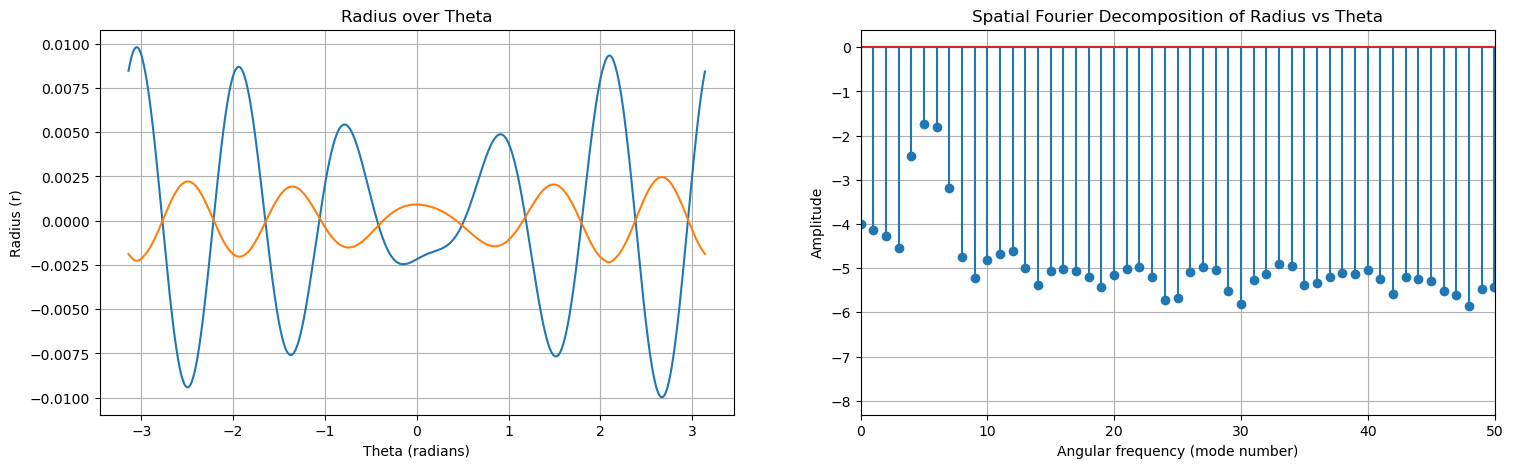

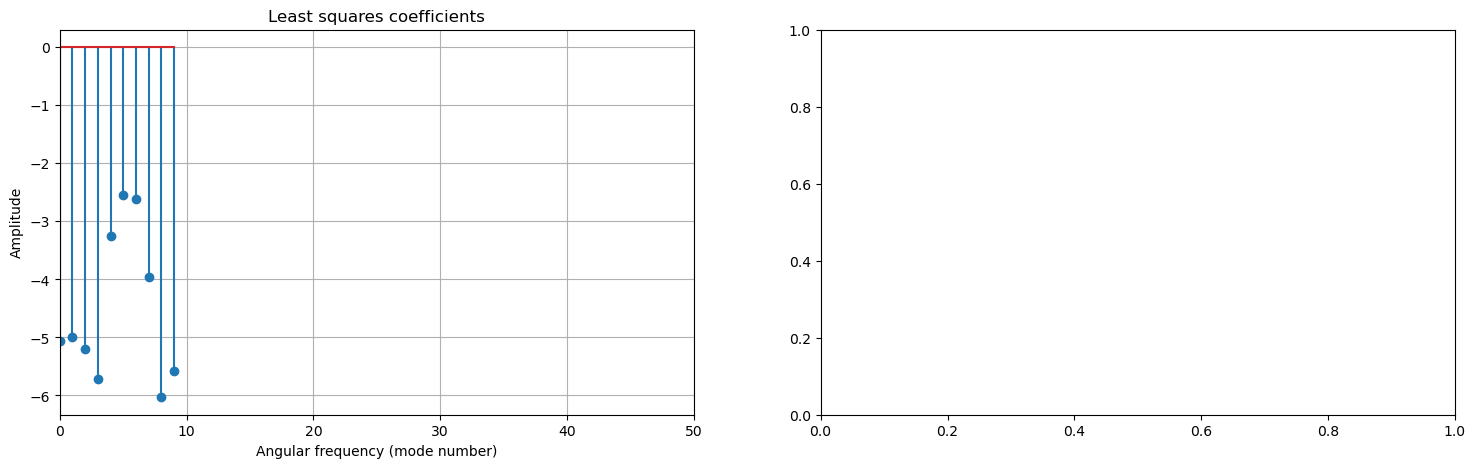

In [200]:
username = os.getlogin()
filepath = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6/Uin_01.50_RUN01/database/Isotherm_t_27.75.okc")
df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
velocity_mag_unsorted = np.sqrt(df['x_velocity'].values ** 2 + df['y_velocity'].values ** 2)

# Get the indices that would sort theta and sort the arrays
sorted_indices = np.argsort(theta_unsorted)
theta = theta_unsorted[sorted_indices]
r_fluc = r_fluc_unsorted[sorted_indices]
velocity_mag = velocity_mag_unsorted[sorted_indices]
vel_mag_fluc = velocity_mag - np.mean(velocity_mag)

# Calculate the interpolated FFT
r_fluc_omega, r_fluc_amp = interpolated_spline_FFT(theta, r_fluc, os_fact=1)

k_plot_lim = 50
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
# Plot r vs. theta
axes[0].plot(theta, r_fluc)
axes[0].plot(theta, vel_mag_fluc)
axes[0].set_xlabel('Theta (radians)')
axes[0].set_ylabel('Radius (r)')
axes[0].set_title('Radius over Theta')
#axes[1].set_xlim(0, 0.01)
axes[0].grid(True)

# Plot the spectrum
axes[1].stem(r_fluc_omega, np.log10(r_fluc_amp))
axes[1].set_xlabel('Angular frequency (mode number)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Spatial Fourier Decomposition of Radius vs Theta')
axes[1].grid(True)
axes[1].set_xlim(0, k_plot_lim)
plt.show()
# Calculate the NUFFT
# n_modes = 201
# r_fluc_amp_nu_lr = finufft.nufft1d1(theta, np.asarray(r_fluc, dtype=np.complex128), n_modes, isign=+1)
# pos_ind_lr = len(r_fluc_amp_nu_lr) // 2
# r_fluc_amp_nu_lr = np.abs(r_fluc_amp_nu_lr[pos_ind_lr:])
# k_lr = [i for i in range(0, pos_ind_lr+1)]

# n_modes = 2001
# r_fluc_amp_nu_hr = finufft.nufft1d1(theta, np.asarray(r_fluc, dtype=np.complex128), n_modes, isign=-1)
# pos_ind_hr = len(r_fluc_amp_nu_hr) // 2
# r_fluc_amp_nu_hr = np.abs(r_fluc_amp_nu_hr[pos_ind_hr:])
# k_hr = [i for i in range(0, pos_ind_hr+1)]

k_ls, r_fluc_amp_ls = least_squares_fit(theta, r_fluc, 10)
# Plot comparison of NUFFT and interpolated FFT
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes[0].stem(k_ls, np.log10(np.abs(r_fluc_amp_ls)))
axes[0].set_xlabel('Angular frequency (mode number)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Least squares coefficients')
axes[0].set_xlim(0, k_plot_lim)
axes[0].grid(True)

# axes[1].stem(k_lr[1:], r_fluc_amp[1:pos_ind_lr+1])# / r_fluc_amp_nu_lr[1:])
# axes[1].set_xlabel('Angular frequency (mode number)')
# axes[1].set_ylabel('Ratio')
# axes[1].set_title('Ratio between interpolated FFT and NUFFT')
# axes[1].set_xlim(0, k_plot_lim)
# axes[1].grid(True)
plt.show()


# plt.plot((np.roll(theta, 1) - theta)[1:] / (2*np.pi/len(theta)), linewidth=0.4)
# plt.show()
# print(r_fluc_amp[:20])
# print(r_fluc_amp_nu_lr[:20])
#dominant_mode = int(r_fluc_omega[np.argmax(r_fluc_amp)])
#print(f"Shape seems to be {dominant_mode}-sided")

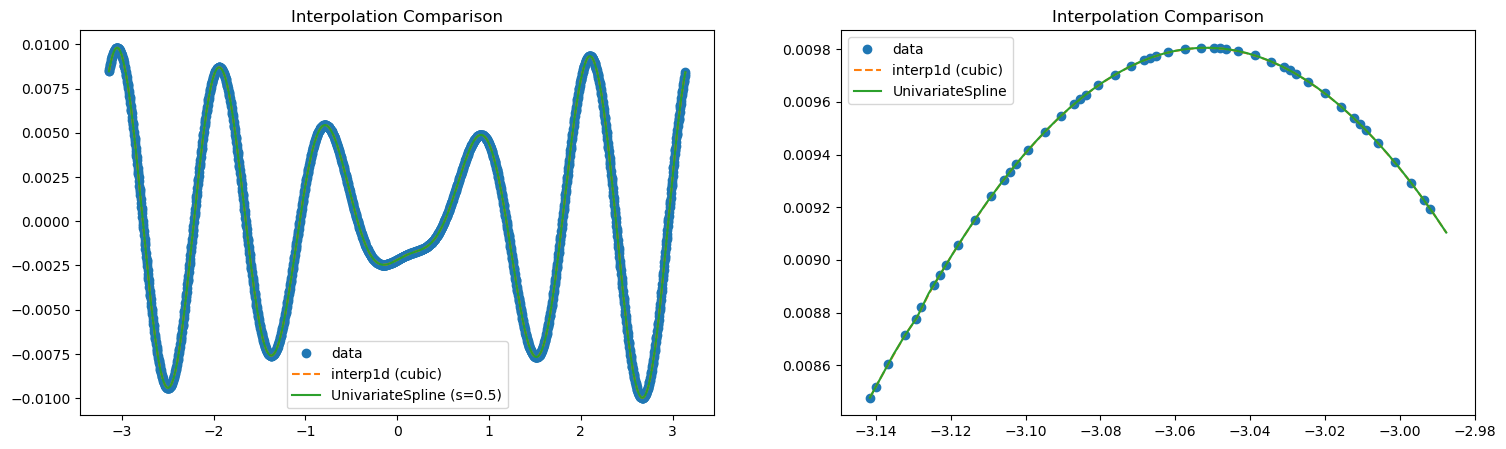

In [190]:
# Noisy data
x = theta
y = r_fluc

x_dense = np.linspace(x[0], x[-1], 2000)

# Exact interpolation (will follow noise)
f_interp = interp1d(x, y, kind='slinear')(x_dense)

# Smooth spline interpolation
f_spline = UnivariateSpline(x, y, s=1e-10)(x_dense)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes[0].plot(x, y, 'o', label='data')
axes[0].plot(x_dense, f_interp, label='interp1d (cubic)', linestyle='--')
axes[0].plot(x_dense, f_spline, label='UnivariateSpline (s=0.5)', linestyle='-')
axes[0].legend()
axes[0].set_title("Interpolation Comparison")

axes[1].plot(x[:50], y[:50], 'o', label='data')
axes[1].plot(x_dense[:50], f_interp[:50], label='interp1d (cubic)', linestyle='--')
axes[1].plot(x_dense[:50], f_spline[:50], label=f'UnivariateSpline', linestyle='-')
axes[1].legend()
axes[1].set_title("Interpolation Comparison")
plt.show()

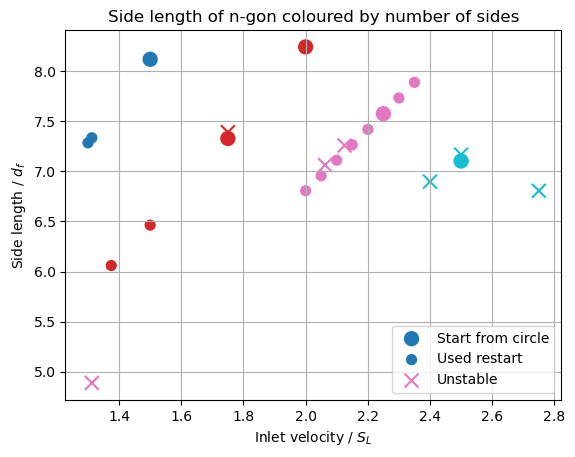

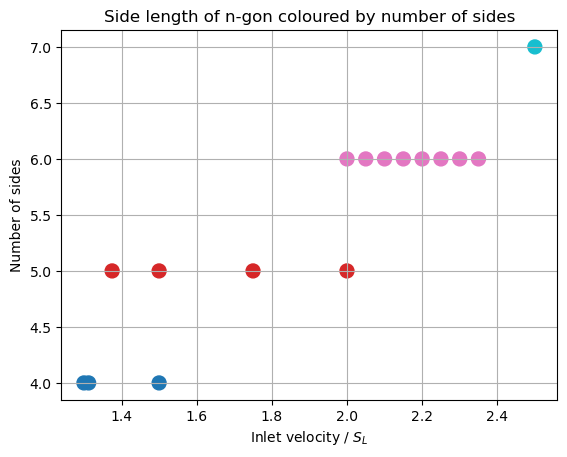

17.25103627841971 6.5684012280012425


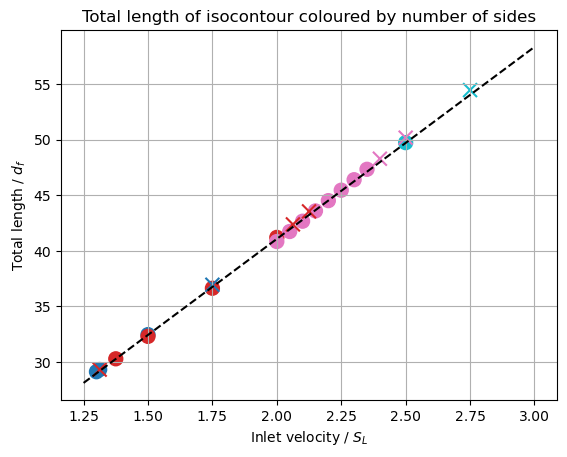

In [149]:
username = os.getlogin()
case1 = "base_18.4k_phi_0.6"
runs = ["01.30_01", "01.3125_03", "01.375_02", "01.50_02", "01.50_03", "01.75_01", "02.00_02", "02.00_06","02.05_01", "02.10_01", 
        "02.15_01", "02.20_01", "02.25_02", "02.30_02", "02.35_01", "02.50_02"]
circle_starts = ["01.50_02", "01.75_01", "02.00_02", "02.25_02", "02.50_02"]
dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1

length_sides = []
num_sides = []
inlet_vels = []
is_nr = []

for run in runs:
    if run in circle_starts:
        is_nr.append(True)
    else:
        is_nr.append(False)

    u_in, run_num = run.split("_")
    run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"

    # find the Isocontour file with the latest time
    db_files_dir = run_dir / "database"
    all_files = os.listdir(db_files_dir)

    # Filter files that match the pattern and extract time
    matches = []
    for f in all_files:
        match = re.match(r"Isotherm_t_(\d+)", f)
        if match:
            time_val = int(match.group(1))
            matches.append((f, time_val))

    # Find the file with the largest time
    if matches:
        final_Isocon = max(matches, key=lambda x: x[1])[0]
    else:
        print("[WARNING] No matching files found.")
    filepath = db_files_dir / final_Isocon
    df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
    theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
    velocity_mag_unsorted = np.sqrt(df['x_velocity'].values ** 2 + df['y_velocity'].values ** 2)

    # Get the indices that would sort theta
    sorted_indices = np.argsort(theta_unsorted)
    theta = theta_unsorted[sorted_indices]
    #r = r_unsorted[sorted_indices]
    r_fluc = r_fluc_unsorted[sorted_indices]
    
    _num_sides = get_dominant_mode(theta, r_fluc)
    num_sides.append(_num_sides)
    inlet_vels.append(float(u_in)) 
    #df = extract_fields_from_okc(run_dir, ['x', 'y', 'x_velocity', 'y_velocity'])
    filepath = run_dir / "timeseries_meanvel_len.csv"
    timeseries = pd.read_csv(filepath, sep=r'\s+')
    total_length = float(timeseries['total_length'].iloc[-1])
    length_sides.append(total_length / _num_sides)

length_sides = np.array(length_sides)
num_sides = np.array(num_sides)
inlet_vels =np.array(inlet_vels)
is_nr = np.array(is_nr)

df = pd.read_csv(f"unstable_cases.csv", skipinitialspace=True)
inlet_vels_us = df['u_in'].values
num_sides_us = df['num_side'].values
tot_length_us = df['l_tot'].values

# Define shared color range
vmin = num_sides.min()
vmax = num_sides.max()
plt.scatter(inlet_vels[is_nr], length_sides[is_nr], c=num_sides[is_nr], cmap='tab10', 
            vmin=vmin, vmax=vmax, s=100, marker='o', label='Start from circle')
plt.scatter(inlet_vels[~is_nr], length_sides[~is_nr], c=num_sides[~is_nr], cmap='tab10', 
            vmin=vmin, vmax=vmax, s=50, marker='o', label='Used restart')
plt.scatter(inlet_vels_us, tot_length_us/num_sides_us, c=num_sides_us, cmap='tab10', 
            vmin=vmin, vmax=vmax, s=100, marker='x', label='Unstable')
plt.xlabel("Inlet velocity / $S_L$")
plt.ylabel("Side length / $d_f$")
plt.title("Side length of n-gon coloured by number of sides")
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(inlet_vels, num_sides, c=num_sides, cmap='tab10', s=100, marker='o')
plt.xlabel("Inlet velocity / $S_L$")
plt.ylabel("Number of sides")
plt.title("Side length of n-gon coloured by number of sides")
#plt.legend()
plt.grid(True)
plt.show()

plt.scatter(inlet_vels, num_sides * length_sides, c=num_sides, cmap='tab10', s=100, marker='o')
plt.scatter(inlet_vels_us, tot_length_us, c=num_sides_us, cmap='tab10', s=100, marker='x')
plt.xlabel("Inlet velocity / $S_L$")
plt.ylabel("Total length / $d_f$")
plt.title("Total length of isocontour coloured by number of sides")
#plt.legend()
plt.grid(True)
l_slope, l_intercept, r_value, p_value, std_err = linregress(inlet_vels, num_sides * length_sides)
#x_fit = np.linspace(min(inlet_vels), max(inlet_vels), 100)
x_fit = np.linspace(1.25, 3.0, 100)
y_fit = l_slope * x_fit + l_intercept
y_pred = 3 * x_fit
plt.plot(x_fit, y_fit, color='black', label='Fit', linestyle='--')
print(l_slope, l_intercept)
#plt.plot(x_fit, y_pred, color='blue', label='Fit')
plt.show()

def predict_shape(u_in, slope, intercept):
    l_tot_pred = u_in * slope + intercept
    num_sides = []
    l_sides = []
    for num_side in range(4,10):
        l_side = l_tot_pred / num_side
        if l_side > 5.8 and l_side < 6.8:
            num_sides.append(num_side)
            l_sides.append(l_side)
    print(num_sides)
    print(l_sides)


In [53]:
username = os.getlogin()
case1 = "base_18.4k_phi_0.6"
#case1 = "large_23.6k_phi_0.6"
#case1 = "base_18.4k_phi_0.75"
#case1 = "le1_18.4k_phi_0.75"
runs = ["01.50_01"]
#runs = ["01.75_01", "01.75_02"]
#runs = ["01.75_01"]
#runs = ["02.00_01", "02.00_02"]
#runs = ["02.25_01", "02.25_02"]
#runs = ["02.50_01", "02.50_02"]
#runs = ["02.75_02"]
#runs = ["02.75_01", "02.75_02"]
#runs = ["03.00_01"]
#runs = ["10.00_02", "10.00_03"]
#runs = ["01.75_03", "01.75_04", "01.75_05", "01.75_06"]

dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1


def extract_fourier_modes(run_list, case_dir, num_modes = 50):
    lengths_list = []
    amp_time_series_list = []
    k_time_series_r_list = []
    time_list = []
    r_mean_series_list = []
    for run in run_list:   
        # Set directories of run
        u_in, run_num = run.split("_")
        run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"
        db_files_dir = run_dir / "database"

        # Extract the total contour lengths
        filepath = run_dir / "timeseries_meanvel_len.csv"
        timeseries = pd.read_csv(filepath, sep=r'\s+')
        total_lengths  = timeseries['total_length'].values

        # Find all files at different times and create empty arrays
        all_files = np.array(os.listdir(db_files_dir))
        k_time_series_r = np.empty((len(all_files), num_modes))
        amp_time_series_r = np.empty((len(all_files), num_modes))
        amp_smooth_time_series_r = np.empty((len(all_files), num_modes))
        k_smooth_time_series_r = np.empty((len(all_files), num_modes))
        time = np.empty((len(all_files)))
        r_mean_time_series = np.empty((len(all_files)))
        no_of_points = np.empty((len(all_files)))
        for i, file in enumerate(all_files):
            match = re.match(r"Isotherm_t_(\d+.\d+)", file)
            time_val = float(match.group(1))
            time[i] = time_val

        sorted_indices = np.argsort(time)
        time = time[sorted_indices]
        all_files = all_files[sorted_indices]
        for i, file in enumerate(all_files):
            filepath = db_files_dir / file
            # Read the file
            df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
            theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
            r_mean_time_series[i] = r_mean
            

            # Sort arrays by theta
            sorted_indices = np.argsort(theta_unsorted)
            theta = theta_unsorted[sorted_indices]
            r_fluc = r_fluc_unsorted[sorted_indices]
            
            # Perform spatial FFT on the real length data
            #r_fluc_k_r, r_fluc_amp_r = interpolated_FFT(theta / (2*np.pi) * total_lengths[i], r_fluc)
            r_fluc_k_r, r_fluc_amp_r = interpolated_spline_FFT(theta * r_mean, r_fluc)
            #r_fluc_amp_r = finufft.nufft1d1(theta, np.asarray(r_fluc, dtype=np.complex128), 50, isign=-1)
            #r_fluc_k_r = []
            #no_of_points[i] = len(r_fluc_amp)
            amp_time_series_r[i] = r_fluc_amp_r[1:num_modes+1]
            k_time_series_r[i,:] = r_fluc_k_r[1:num_modes+1]

        k_fixed = k_time_series_r[10]
        #print(k_fixed)
        #print(r_mean_time_series)
        for i, file in enumerate(all_files):
            filepath = db_files_dir / file
            # Read the file
            df = extract_fields_from_okc(filepath, ['x', 'y'])
            theta_unsorted, r_mean, r_fluc_unsorted = cartesian_df_to_polar(df)
            #r_mean_time_series[i] = r_mean
            #print(len(theta_unsorted))
            # Sort arrays by theta
            sorted_indices = np.argsort(theta_unsorted)
            theta = theta_unsorted[sorted_indices]
            r_fluc = r_fluc_unsorted[sorted_indices]
            # Use finufft type-1 (nonuniform to uniform)
            nu_fixed_norm = k_fixed * r_mean
            nu_non_fixed = np.arange(num_modes)*0.1
            k_smooth, amp_smooth_r = interpolated_NUFFT(theta, r_fluc, nu_non_fixed)
            #k_smooth, amp_smooth_r = interpolated_smooth_FFT(theta * r_mean, r_fluc, n_grid = 2000, n_modes=num_modes+1, smoothing=1e-9)
            #k_smooth, amp_smooth_r = least_squares_fit(theta, r_fluc, modes=nu_fixed_norm)
            amp_smooth_time_series_r[i] = np.abs(amp_smooth_r[:num_modes])
            k_smooth_time_series_r[i] = k_smooth[:num_modes]

        # Create list from all run arrays
        lengths_list.append(total_lengths)
        time_list.append(time)
        amp_time_series_list.append(amp_time_series_r)
        k_time_series_r_list.append(k_time_series_r)
        r_mean_series_list.append(r_mean_time_series)
    # Concatenate arrays into one
    lengths_tot = np.concatenate(lengths_list)
    time_tot = np.concatenate(time_list)
    amp_tot = np.concatenate(amp_time_series_list)
    k_r_tot = np.concatenate(k_time_series_r_list)
    r_mean_tot = np.concatenate(r_mean_series_list)
    return lengths_tot, time_tot, amp_tot, k_r_tot, r_mean_tot, amp_smooth_time_series_r, k_smooth_time_series_r


lengths_tot, time_tot, amp_tot, k_r_tot, r_mean_tot, amp_sm_tot, k_sm_tot = extract_fourier_modes(runs, case_dir)

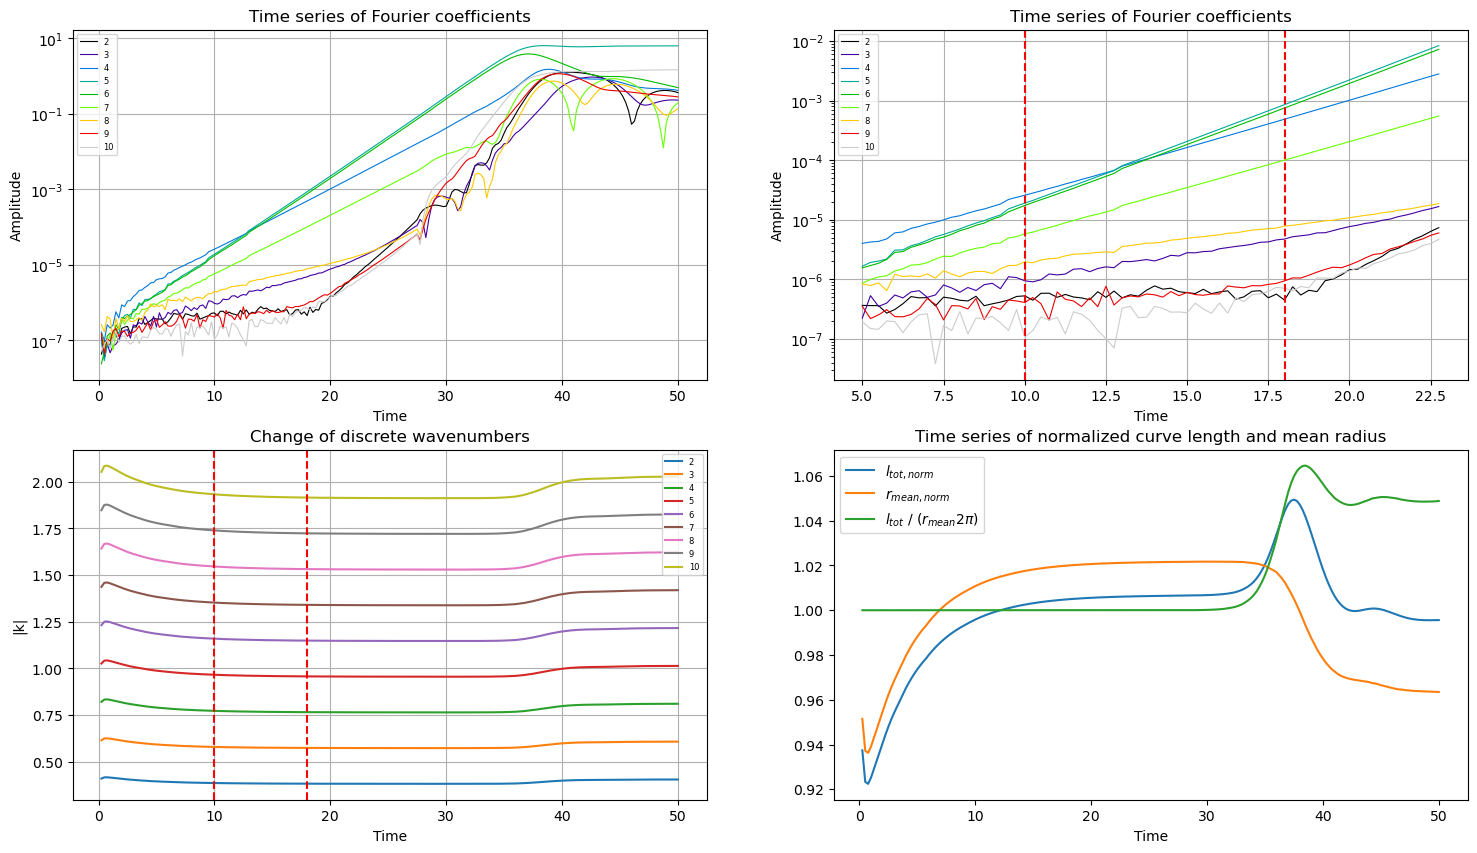

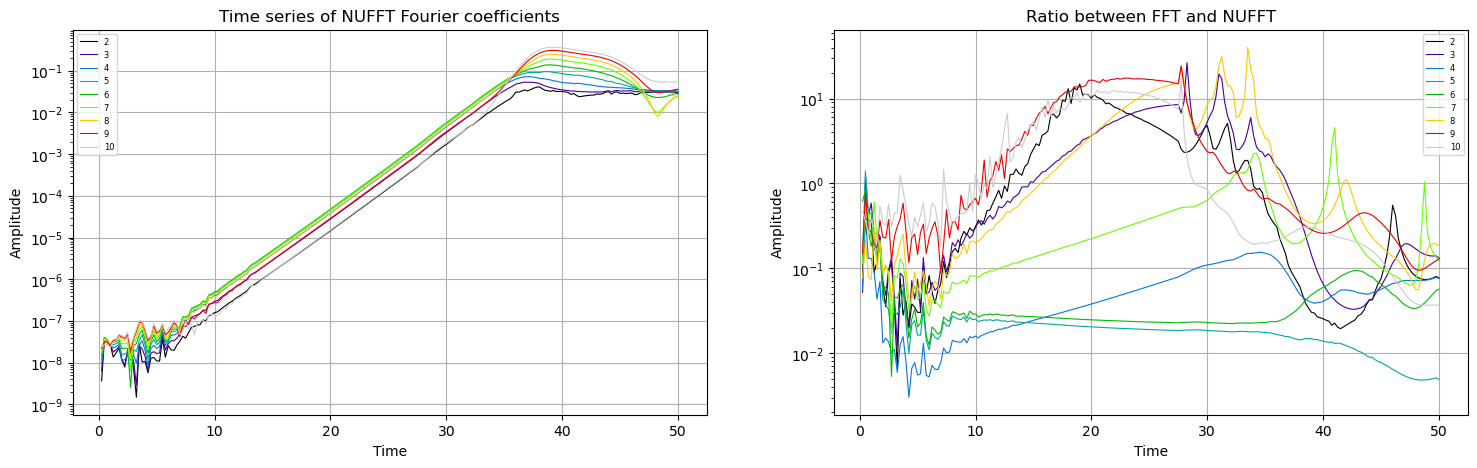

0.459	0.601	0.0090
0.460	0.801	0.0090
0.461	1.001	0.0090
0.462	1.202	0.0090
0.464	1.402	0.0090
0.467	1.602	0.0090
32.688630987657234


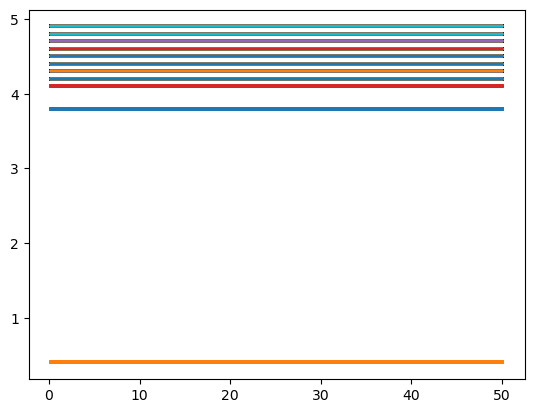

In [58]:
# Extract dispersion relation
plt_s = slice(1, 10)
#modes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13] # Mode n-1
modes = list(range(2, 8))
t_start = 10
t_end = 18
t_start_ind = closest_index = np.argmin(np.abs(time_tot - t_start))
t_end_ind = closest_index = np.argmin(np.abs(time_tot - t_end))

my_cmap = plt.get_cmap('nipy_spectral')
colors = my_cmap(np.linspace(0, 1, (plt_s.stop - plt_s.start)))

# Plot whole time series of fourier coefficients
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
for i in range(plt_s.start, plt_s.stop):
    axes[0, 0].semilogy(time_tot, amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Time series of Fourier coefficients')
axes[0, 0].grid(True)
axes[0, 0].legend(prop={'size': 6})

# Plot narrowed range to show linear growth better
for i in range(plt_s.start, plt_s.stop):
    axes[0, 1].semilogy(time_tot[max(0, t_start_ind-20):t_end_ind+20], amp_tot[max(0, t_start_ind-20):t_end_ind+20,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0, 1].axvline(x=t_start, color='red', linestyle='--')
axes[0, 1].axvline(x=t_end, color='red', linestyle='--')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Time series of Fourier coefficients')
axes[0, 1].grid(True)
axes[0, 1].legend(prop={'size': 6})

# Plot change of wavenumber
axes[1, 0].plot(time_tot, k_r_tot[:,plt_s.start:plt_s.stop])
axes[1, 0].axvline(x=t_start, color='red', linestyle='--')
axes[1, 0].axvline(x=t_end, color='red', linestyle='--')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('|k|')
axes[1, 0].set_title('Change of discrete wavenumbers')
axes[1, 0].grid(True)
axes[1, 0].legend([str(i+1) for i in range(plt_s.start, plt_s.stop)], prop={'size': 6})

# Plot total length (inverse prop. to |k|)
axes[1, 1].plot(time_tot, lengths_tot/np.mean(lengths_tot), label='$l_{tot,norm}$')
axes[1, 1].plot(time_tot, r_mean_tot/np.mean(r_mean_tot), label='$r_{mean,norm}$')
axes[1, 1].plot(time_tot, lengths_tot/r_mean_tot/(2*np.pi), label=r'$l_{tot}$ / ($r_{mean} 2 \pi$)')
axes[1, 1].set_title('Time series of normalized curve length and mean radius')
axes[1, 1].set_xlabel('Time')
axes[1, 1].legend(prop={'size': 10})
plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(18, 5))
# axes[0].plot(time_tot, num_samples, linewidth=0.8)
# axes[0].set_xlabel('Time')
# axes[0].set_ylabel('#')
# axes[0].set_title('number of samples')
# axes[0].grid(True)
# axes[0].legend(prop={'size': 6})
# print(k_r_tot[10, 1:20])

# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
for i in range(plt_s.start, plt_s.stop):
    axes[0].semilogy(time_tot, np.abs(amp_sm_tot[:,i]), color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Time series of NUFFT Fourier coefficients')
axes[0].grid(True)
axes[0].legend(prop={'size': 6})
#print(k_r_tot[10, 1:20])

for i in range(plt_s.start, plt_s.stop):
    axes[1].semilogy(time_tot, np.abs(amp_sm_tot[:,i]) / amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Ratio between FFT and NUFFT')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
plt.show()

log_modes = np.log(amp_sm_tot[:,modes])
slope_list = np.empty((log_modes.shape[1], 2))

for i in range(log_modes.shape[1]):
    slope, intercept, r_value, p_value, std_err = linregress(time_tot[t_start_ind:t_end_ind], log_modes[t_start_ind:t_end_ind, i])
    k_mean = np.mean(k_r_tot[t_start:t_end, modes[i]])
    k_rel_change = (k_r_tot[t_end_ind, modes[i]] - k_r_tot[t_start_ind, modes[i]]) / k_r_tot[t_start_ind, modes[i]]
    print(f"{slope:.3f}\t{k_mean:.3f}\t{abs(k_rel_change):.4f}")
    slope_list[i,1] = slope
    slope_list[i,0] = k_mean

for i in range(len(time_tot)):
    plt.plot(time_tot, k_sm_tot[:,np.argmax(amp_sm_tot, axis=1)])
print(np.mean(lengths_tot[t_start_ind:t_end_ind]))

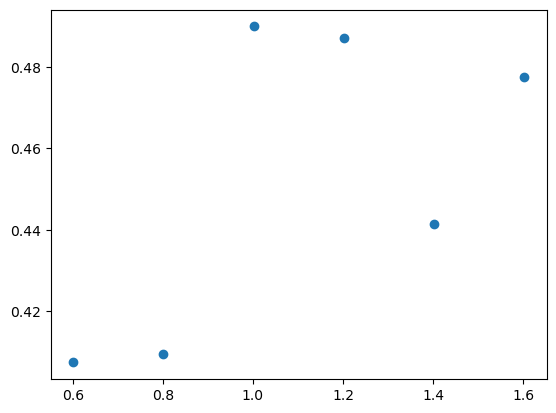

In [28]:
#fig = plt.figure()
#print(slope_list)
plt.scatter(slope_list[:,0], slope_list[:,1])
#plt.show()
#plt.plot(k_mean_list, slope_list)

In [ ]:
username = os.getlogin()
case1 = "base_18.4k_phi_0.6"
#case1 = "large_23.6k_phi_0.6"
#case1 = "base_18.4k_phi_0.75"
#case1 = "le1_18.4k_phi_0.75"
runs = ["01.75_02", "01.75_03", "01.75_04", "01.75_05", "01.75_06", "01.75_07"]
dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1
plt_s = slice(1, 15)

lengths_tot, time_tot, amp_tot, k_r_tot, r_mean_tot = extract_fourier_modes(runs, case_dir)

my_cmap = plt.get_cmap('nipy_spectral')
colors = my_cmap(np.linspace(0, 1, (plt_s.stop - plt_s.start)))

# Plot whole time series of fourier coefficients
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for i in range(plt_s.start, plt_s.stop):
    axes[0].semilogy(time_tot, amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Time series of Fourier coefficients')
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

for i in range(plt_s.start, plt_s.stop):
    axes[1].plot(time_tot, amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Time series of Fourier coefficients')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})

plt.figure(figsize=(9, 6))
plt.plot(time_tot, lengths_tot/np.mean(lengths_tot))
plt.plot(time_tot, r_mean_tot/np.mean(r_mean_tot))
plt.title('Time series of normalized curve length and mean radius')
plt.xlabel('Time')
plt.show()

In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display

# Assuming your simulation cases are in a directory, e.g., './cases'
case_base_dir =  Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dirs = [d for d in os.listdir(case_base_dir) if os.path.isdir(os.path.join(case_base_dir, d))]

case_selector = widgets.Dropdown(
    options=case_dirs,
    description='Case:',
    disabled=False,
)

display(case_selector)
print(case_selector)


In [ ]:
selected_case = case_selector.value
selected_case_path = os.path.join(case_base_dir, selected_case)
print(selected_case_path)